In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/FANG.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,19.459999,19.920000,18.600000,19.240000,18.924437,189700
1,1/3/2013,19.240000,19.459999,18.650000,19.139999,18.826073,89100
2,1/4/2013,19.250000,20.490000,18.969999,20.049999,19.721148,173300
3,1/7/2013,19.889999,21.240000,19.639999,20.770000,20.429340,210300
4,1/8/2013,20.690001,21.100000,20.379999,20.600000,20.262127,229400


In [3]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 10
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
epoch: 10, total rewards: 1180.239967.3, cost: 0.190737, total money: 471.979980
epoch: 20, total rewards: 190.689998.3, cost: 0.036310, total money: 6176.880000
epoch: 30, total rewards: 197.319987.3, cost: 0.022464, total money: 7863.909991
epoch: 40, total rewards: 21.040013.3, cost: 0.025477, total money: 6613.890012
epoch: 50, total rewards: 48.839963.3, cost: 0.018610, total money: 7391.329953
epoch: 60, total rewards: 272.529952.3, cost: 0.011485, total money: 8375.559951
epoch: 70, total rewards: 105.689940.3, cost: 0.013010, total money: 7833.739936
epoch: 80, total rewards: 105.299905.3, cost: 0.011672, total money: 7940.559899
epoch: 90, total rewards: 188.349923.3, cost: 0.007543, total money: 8656.619920
epoch: 100, total rewards: 200.579922.3, cost: 0.007598, total money: 8512.009915
epoch: 110, to

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 4: buy 1 unit at price 20.600000, total balance 9979.400000
day 6, sell 1 unit at price 21.629999, investment 4.999994 %, total balance 10001.029999,
day 16: buy 1 unit at price 22.000000, total balance 9979.029999
day 17: buy 1 unit at price 21.639999, total balance 9957.389999
day 18, sell 1 unit at price 22.129999, investment 0.590905 %, total balance 9979.519999,
day 21: buy 1 unit at price 22.700001, total balance 9956.819998
day 22, sell 1 unit at price 22.540001, investment 4.158972 %, total balance 9979.359999,
day 23: buy 1 unit at price 22.629999, total balance 9956.730000
day 24, sell 1 unit at price 22.629999, investment -0.308377 %, total balance 9979.359999,
day 25, sell 1 unit at price 22.420000, investment -0.927968 %, total balance 10001.779999,
day 26: buy 1 unit at price 22.049999, total balance 9979.730000
day 27, sell 1 unit at price 21.559999, investment -2.222221 %, total balance 10001.289999,
day 35: buy 1 unit at price 20.980000, total balance 9980.309999
d

day 216: buy 1 unit at price 53.470001, total balance 9831.209986
day 217: buy 1 unit at price 53.290001, total balance 9777.919985
day 219: buy 1 unit at price 53.150002, total balance 9724.769983
day 220, sell 1 unit at price 53.119999, investment -0.747387 %, total balance 9777.889982,
day 221, sell 1 unit at price 53.529999, investment -0.335134 %, total balance 9831.419981,
day 222, sell 1 unit at price 50.209999, investment -5.549287 %, total balance 9881.629980,
day 223: buy 1 unit at price 48.820000, total balance 9832.809980
day 226, sell 1 unit at price 51.529999, investment -3.628207 %, total balance 9884.339979,
day 227: buy 1 unit at price 50.880001, total balance 9833.459978
day 229: buy 1 unit at price 50.060001, total balance 9783.399977
day 230, sell 1 unit at price 49.740002, investment -6.661661 %, total balance 9833.139978,
day 232: buy 1 unit at price 50.230000, total balance 9782.909979
day 233, sell 1 unit at price 50.450001, investment -5.079964 %, total balance

day 394: buy 1 unit at price 84.800003, total balance 9913.019995
day 396, sell 1 unit at price 84.750000, investment -2.091032 %, total balance 9997.769995,
day 397, sell 1 unit at price 82.230003, investment -3.030660 %, total balance 10079.999998,
day 399: buy 1 unit at price 81.610001, total balance 9998.389998
day 400, sell 1 unit at price 78.930000, investment -3.283912 %, total balance 10077.319998,
day 401: buy 1 unit at price 78.519997, total balance 9998.800001
day 402: buy 1 unit at price 76.580002, total balance 9922.219999
day 403: buy 1 unit at price 77.449997, total balance 9844.770002
day 404, sell 1 unit at price 77.489998, investment -1.311766 %, total balance 9922.260000,
day 405: buy 1 unit at price 76.040001, total balance 9846.219999
day 407, sell 1 unit at price 75.860001, investment -0.940195 %, total balance 9922.080000,
day 408, sell 1 unit at price 78.449997, investment 1.291156 %, total balance 10000.529997,
day 410: buy 1 unit at price 80.000000, total bala

day 545, sell 1 unit at price 71.809998, investment 0.842576 %, total balance 10028.079985,
day 546, sell 1 unit at price 71.180000, investment 0.281765 %, total balance 10099.259985,
day 547: buy 1 unit at price 69.860001, total balance 10029.399984
day 548, sell 1 unit at price 69.610001, investment -0.357859 %, total balance 10099.009985,
day 550: buy 1 unit at price 70.050003, total balance 10028.959982
day 552: buy 1 unit at price 69.680000, total balance 9959.279982
day 554: buy 1 unit at price 70.470001, total balance 9888.809980
day 555: buy 1 unit at price 72.650002, total balance 9816.159979
day 556, sell 1 unit at price 71.489998, investment 2.055667 %, total balance 9887.649977,
day 558: buy 1 unit at price 71.580002, total balance 9816.069975
day 559, sell 1 unit at price 73.769997, investment 5.869685 %, total balance 9889.839972,
day 563, sell 1 unit at price 77.629997, investment 10.160346 %, total balance 9967.469969,
day 564: buy 1 unit at price 76.839996, total balan

day 715: buy 1 unit at price 77.260002, total balance 8897.299963
day 716, sell 1 unit at price 76.080002, investment 14.062976 %, total balance 8973.379965,
day 717: buy 1 unit at price 77.089996, total balance 8896.289969
day 719: buy 1 unit at price 79.620003, total balance 8816.669966
day 720, sell 1 unit at price 79.599998, investment 15.362317 %, total balance 8896.269964,
day 721: buy 1 unit at price 79.830002, total balance 8816.439962
day 722: buy 1 unit at price 78.089996, total balance 8738.349966
day 723, sell 1 unit at price 76.720001, investment 10.515706 %, total balance 8815.069967,
day 724, sell 1 unit at price 79.660004, investment 15.148892 %, total balance 8894.729971,
day 725, sell 1 unit at price 79.610001, investment 19.409034 %, total balance 8974.339972,
day 726, sell 1 unit at price 81.419998, investment 23.344941 %, total balance 9055.759970,
day 727, sell 1 unit at price 77.059998, investment 6.172493 %, total balance 9132.819967,
day 728, sell 1 unit at pri

day 908: buy 1 unit at price 93.290001, total balance 9848.449968
day 909: buy 1 unit at price 94.160004, total balance 9754.289965
day 910: buy 1 unit at price 94.580002, total balance 9659.709963
day 912, sell 1 unit at price 95.010002, investment 6.180150 %, total balance 9754.719965,
day 914, sell 1 unit at price 98.550003, investment 14.686376 %, total balance 9853.269968,
day 915, sell 1 unit at price 98.589996, investment 14.706224 %, total balance 9951.859964,
day 916: buy 1 unit at price 96.489998, total balance 9855.369967
day 917: buy 1 unit at price 96.589996, total balance 9758.779970
day 918, sell 1 unit at price 96.190002, investment 8.188054 %, total balance 9854.969973,
day 919, sell 1 unit at price 96.260002, investment 3.561060 %, total balance 9951.229975,
day 920, sell 1 unit at price 96.330002, investment 3.258657 %, total balance 10047.559977,
day 921: buy 1 unit at price 97.360001, total balance 9950.199976
day 922, sell 1 unit at price 96.500000, investment 2.4

day 1073: buy 1 unit at price 104.669998, total balance 9501.829989
day 1074: buy 1 unit at price 104.379997, total balance 9397.449991
day 1075, sell 1 unit at price 104.620003, investment 0.038249 %, total balance 9502.069994,
day 1079, sell 1 unit at price 105.139999, investment 3.606618 %, total balance 9607.209993,
day 1081: buy 1 unit at price 100.550003, total balance 9506.659990
day 1084, sell 1 unit at price 101.760002, investment -0.352527 %, total balance 9608.419992,
day 1085, sell 1 unit at price 103.970001, investment 2.767622 %, total balance 9712.389994,
day 1087: buy 1 unit at price 100.449997, total balance 9611.939997
day 1088, sell 1 unit at price 99.839996, investment 0.909636 %, total balance 9711.779993,
day 1089: buy 1 unit at price 98.959999, total balance 9612.819994
day 1090: buy 1 unit at price 98.379997, total balance 9514.439997
day 1092, sell 1 unit at price 95.209999, investment -7.265997 %, total balance 9609.649996,
day 1093, sell 1 unit at price 99.65

day 1231: buy 1 unit at price 107.970001, total balance 10420.429956
day 1232, sell 1 unit at price 109.150002, investment 1.092896 %, total balance 10529.579958,
day 1234: buy 1 unit at price 110.300003, total balance 10419.279955
day 1235: buy 1 unit at price 107.260002, total balance 10312.019953
day 1236: buy 1 unit at price 108.230003, total balance 10203.789949
day 1237: buy 1 unit at price 108.150002, total balance 10095.639948
day 1238: buy 1 unit at price 109.309998, total balance 9986.329950
day 1240: buy 1 unit at price 109.019997, total balance 9877.309954
day 1242, sell 1 unit at price 106.330002, investment -3.599276 %, total balance 9983.639955,
day 1243: buy 1 unit at price 108.949997, total balance 9874.689958
day 1245: buy 1 unit at price 111.300003, total balance 9763.389955
day 1247, sell 1 unit at price 111.589996, investment 4.036914 %, total balance 9874.979952,
day 1248: buy 1 unit at price 111.029999, total balance 9763.949953
day 1249: buy 1 unit at price 109.

day 1380: buy 1 unit at price 126.540001, total balance 8024.679979
day 1384, sell 1 unit at price 129.300003, investment 2.823064 %, total balance 8153.979982,
day 1385: buy 1 unit at price 130.050003, total balance 8023.929979
day 1386: buy 1 unit at price 132.000000, total balance 7891.929979
day 1388: buy 1 unit at price 136.669998, total balance 7755.259981
day 1389, sell 1 unit at price 133.960007, investment 5.231739 %, total balance 7889.219987,
day 1390, sell 1 unit at price 130.759995, investment 0.399254 %, total balance 8019.979982,
day 1391: buy 1 unit at price 130.279999, total balance 7889.699983
day 1394: buy 1 unit at price 130.649994, total balance 7759.049989
day 1397, sell 1 unit at price 131.149994, investment 1.047847 %, total balance 7890.199983,
day 1398: buy 1 unit at price 131.169998, total balance 7759.029985
day 1399: buy 1 unit at price 133.449997, total balance 7625.579988
day 1400, sell 1 unit at price 134.679993, investment 8.403087 %, total balance 7760

day 1543, sell 1 unit at price 106.449997, investment 11.793736 %, total balance 9314.849992,
day 1544: buy 1 unit at price 102.139999, total balance 9212.709992
day 1545: buy 1 unit at price 104.029999, total balance 9108.679993
day 1547, sell 1 unit at price 105.510002, investment 0.533592 %, total balance 9214.189995,
day 1549, sell 1 unit at price 102.930000, investment -3.015167 %, total balance 9317.119996,
day 1550, sell 1 unit at price 104.790001, investment 0.662827 %, total balance 9421.909997,
day 1551, sell 1 unit at price 104.669998, investment 0.153092 %, total balance 9526.579995,
day 1552: buy 1 unit at price 102.620003, total balance 9423.959992
day 1553: buy 1 unit at price 100.050003, total balance 9323.909989
day 1556, sell 1 unit at price 97.580002, investment -4.529887 %, total balance 9421.489991,
day 1557, sell 1 unit at price 100.500000, investment 0.339453 %, total balance 9521.989991,
day 1558, sell 1 unit at price 103.419998, investment 1.511583 %, total bal

day 1691: buy 1 unit at price 96.820000, total balance 8246.019944
day 1693, sell 1 unit at price 94.489998, investment -5.254192 %, total balance 8340.509942,
day 1694: buy 1 unit at price 93.239998, total balance 8247.269944
day 1695, sell 1 unit at price 90.120003, investment -7.474331 %, total balance 8337.389947,
day 1697: buy 1 unit at price 89.910004, total balance 8247.479943
day 1698: buy 1 unit at price 85.000000, total balance 8162.479943
day 1700, sell 1 unit at price 85.889999, investment -5.677573 %, total balance 8248.369942,
day 1702, sell 1 unit at price 83.370003, investment -12.426465 %, total balance 8331.739945,
day 1703, sell 1 unit at price 80.820000, investment -16.083479 %, total balance 8412.559945,
day 1704: buy 1 unit at price 81.550003, total balance 8331.009942
day 1705, sell 1 unit at price 82.540001, investment -13.850326 %, total balance 8413.549943,
day 1706: buy 1 unit at price 83.639999, total balance 8329.909943
day 1707: buy 1 unit at price 83.9599

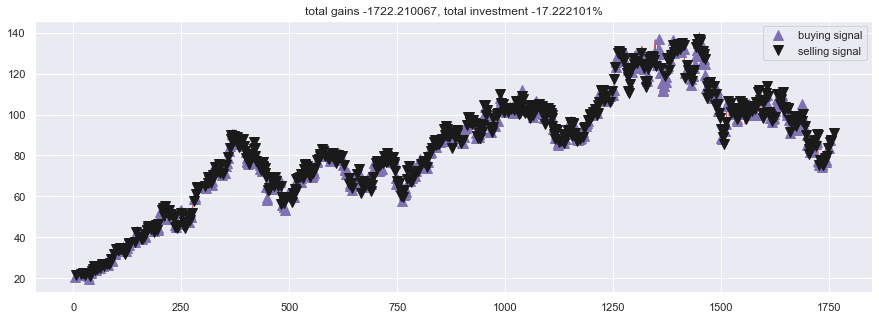

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=1)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()